/Users/cleazhang/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cleazhang/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cleazhang/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Training Confusion Matrix:
  [[3099  203]
 [ 267  139]]

Testing Confusion Matrix:
  [[341  25]
 [ 33  12]]

Training Accuracy Score:  0.8732470334412082

Testing Accuracy Score:  0.8588807785888077

Training Precision:  0.4064327485380117

Testing Precision:  0.32432432432432434

Training Recall:  0.34236453201970446

Testing Recall:  0.26666666666666666

Train Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.94      0.93      3302
           1       0.41      0.34      0.37       406

    accuracy                           0.87      3708
   macro avg       0.66      0.64      0.65      3708
weighted avg       0.86      0.87      0.87      3708


Test Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.93      0.92       366
           1       0.32      0.27      0.29        45

    accuracy                           0.86       411
   macro avg       0.62      0.60

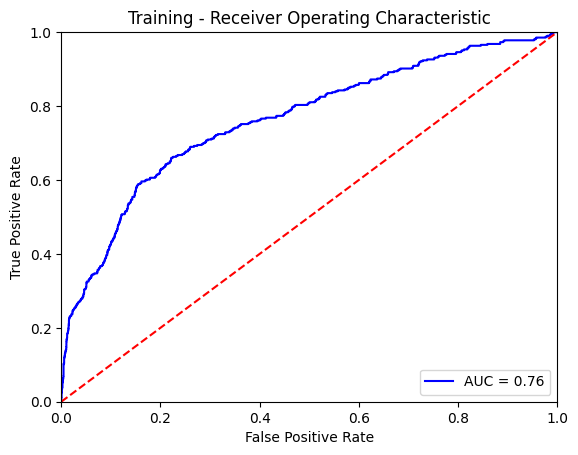

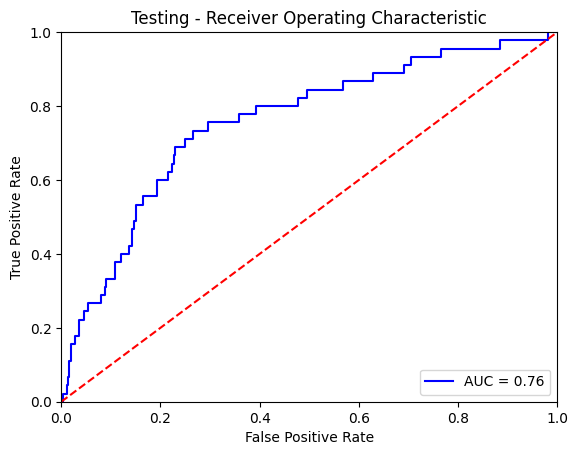

In [5]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB, MultinomialNB
#from imblearn.over_sampling import SMOTE
from evaluate_classifier_performance import evaluate_classifier_performance

df_train = pd.read_csv('/Users/cleazhang/Downloads/bank-additional-dataset/kfold_fold_10_train.csv')
df_test = pd.read_csv('/Users/cleazhang/Downloads/bank-additional-dataset/kfold_fold_10_test.csv')
# del df_train['Unnamed: 0']
# del df_test['Unnamed: 0']


df_train_class = pd.DataFrame(df_train['y'])    
df_train_features = df_train.loc[:, df_train.columns != 'y']

df_test_class = pd.DataFrame(df_test['y'])
df_test_features = df_test.loc[:, df_test.columns != 'y']

'''
### Resampling to balance the dataset
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(df_train_features, df_train_class)
df_train_features = pd.DataFrame(X_res, columns=df_train_features.columns)
df_train_class = pd.DataFrame(y_res, columns=df_train_class.columns)
'''
### separate Continuous and Multinmoial Features
continuous_features = ['age', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

df_train_features_cont = df_train_features.loc[:,df_train_features.columns.isin(continuous_features)]
df_train_features_cate =  df_train_features.loc[:,~df_train_features.columns.isin(continuous_features)]

df_test_features_cont = df_test_features.loc[:, df_test_features.columns.isin(continuous_features)]
df_test_features_cate =  df_test_features.loc[:,~df_test_features.columns.isin(continuous_features)]

### Fit Gaussian NB model
gaussian_nb = GaussianNB()
gaussian_nb.fit(df_train_features_cont, df_train_class)

gaussian_predicted_prob_train = gaussian_nb.predict_proba(df_train_features_cont)
gaussian_predicted_prob_test = gaussian_nb.predict_proba(df_test_features_cont)

### Fit Multinomial NB model
multinomial_nb = MultinomialNB()
multinomial_nb.fit(df_train_features_cate, df_train_class)

multinomial_predicted_prob_train = multinomial_nb.predict_proba(df_train_features_cate)
multinomial_predicted_prob_test = multinomial_nb.predict_proba(df_test_features_cate)

### Fit probabilites on Gaussian again

combined_predicted_prob_train = np.vstack([gaussian_predicted_prob_train[:,1],multinomial_predicted_prob_train[:,1]]).T
combined_predicted_prob_test = np.vstack([gaussian_predicted_prob_test[:,1],multinomial_predicted_prob_test[:,1]]).T

gaussian_nb_final = GaussianNB()
gaussian_nb_final.fit(combined_predicted_prob_train, df_train_class)

predicted_train = gaussian_nb_final.predict(combined_predicted_prob_train)
predicted_test = gaussian_nb_final.predict(combined_predicted_prob_test)

predicted_prob_train = gaussian_nb_final.predict_proba(combined_predicted_prob_train)
predicted_prob_test = gaussian_nb_final.predict_proba(combined_predicted_prob_test)

evaluate_classifier_performance(df_train_class, predicted_train, predicted_prob_train, df_test_class, predicted_test, predicted_prob_test, 'y')



=== Test average performance ===
Accuracy:  0.8701
Precision: 0.3877
Recall:    0.3215
F1-score:  0.3515
F1-score (weighted): 0.8647
ROC AUC:   0.7473


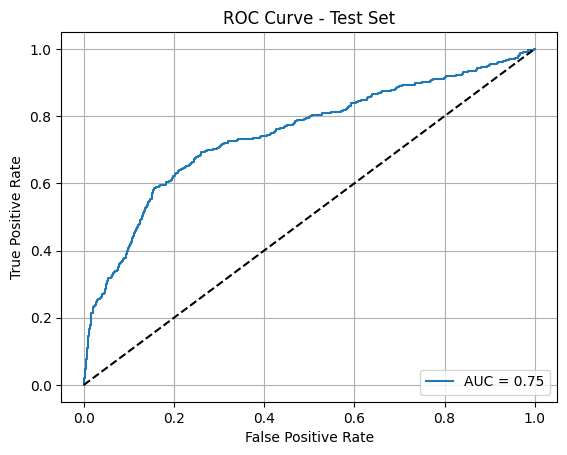


=== Train average performance ===
Accuracy:  0.8715
Precision: 0.3960
Recall:    0.3306
F1-score:  0.3604
F1-score (weighted): 0.8664
ROC AUC:   0.7563


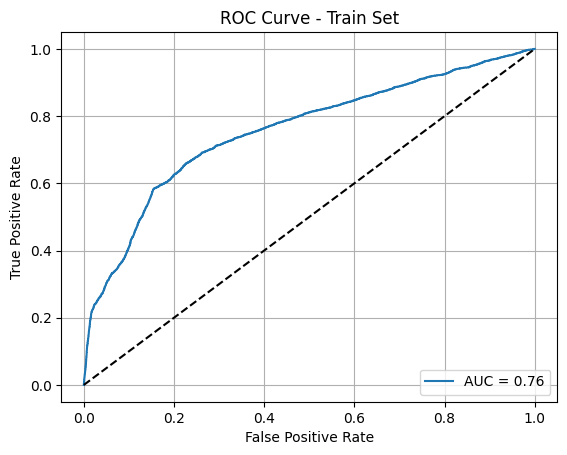

In [6]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import classification_report
from evaluate_classifier_performance_cv import evaluate_classifier_performance_cv

# 定义特征类别
continuous_features = ['age', 'campaign', 'previous', 'emp.var.rate', 
                       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

# 结果存储
all_train_reports = []
all_test_reports = []



all_y_true_test = []
all_y_pred_test = []
all_y_prob_test = []


all_y_true_train = []
all_y_pred_train = []
all_y_prob_train = []


# 遍历 10 折数据集
for fold_idx in range(1, 11):  # 遍历 kfold_fold_1 到 kfold_fold_10

    train_file = f'/Users/cleazhang/Downloads/bank-additional-dataset/kfold_fold_{fold_idx}_train.csv'
    test_file = f'/Users/cleazhang/Downloads/bank-additional-dataset/kfold_fold_{fold_idx}_test.csv'

    # 读取数据
    df_train = pd.read_csv(train_file)
    df_test = pd.read_csv(test_file)

    # 分离标签和特征
    df_train_class = df_train['y']
    df_train_features = df_train.drop(columns=['y'])
    
    df_test_class = df_test['y']
    df_test_features = df_test.drop(columns=['y'])

    # **分离连续和离散特征**
    df_train_features_cont = df_train_features[continuous_features]
    df_train_features_cate = df_train_features.drop(columns=continuous_features)

    df_test_features_cont = df_test_features[continuous_features]
    df_test_features_cate = df_test_features.drop(columns=continuous_features)

    # **训练 GaussianNB（连续特征）**
    gaussian_nb = GaussianNB()
    gaussian_nb.fit(df_train_features_cont, df_train_class)

    gaussian_train_probs = gaussian_nb.predict_proba(df_train_features_cont)
    gaussian_test_probs = gaussian_nb.predict_proba(df_test_features_cont)

    # **训练 MultinomialNB（离散特征）**
    multinomial_nb = MultinomialNB()
    multinomial_nb.fit(df_train_features_cate, df_train_class)

    multinomial_train_probs = multinomial_nb.predict_proba(df_train_features_cate)
    multinomial_test_probs = multinomial_nb.predict_proba(df_test_features_cate)

    # **组合两个模型的概率**
    combined_train_probs = np.vstack([gaussian_train_probs[:, 1], multinomial_train_probs[:, 1]]).T
    combined_test_probs = np.vstack([gaussian_test_probs[:, 1], multinomial_test_probs[:, 1]]).T

    # **最终分类器（GaussianNB）**
    final_nb = GaussianNB()
    final_nb.fit(combined_train_probs, df_train_class)

    # **预测最终结果**
    predicted_train = final_nb.predict(combined_train_probs)
    predicted_test = final_nb.predict(combined_test_probs)


    predicted_prob_train = final_nb.predict_proba(combined_train_probs)  # shape: (N, 2)
    # predicted_prob_test 是最终预测“为正类（1）”的概率
    predicted_prob_test = final_nb.predict_proba(combined_test_probs)  # shape: (N, 2)

    # 收集 test 集指标用于统计平均
    all_y_true_test.extend(df_test_class)
    all_y_pred_test.extend(predicted_test)
    all_y_prob_test.extend(predicted_prob_test[:, 1])

    all_y_true_train.extend(df_train_class)
    all_y_pred_train.extend(predicted_train)
    all_y_prob_train.extend(predicted_prob_train[:, 1])


    # # **计算性能指标**
    # train_report = classification_report(df_train_class, predicted_train, output_dict=True)
    # test_report = classification_report(df_test_class, predicted_test, output_dict=True)

    # all_train_reports.append(train_report)
    # all_test_reports.append(test_report)

# # === 计算 10 折的平均性能 ===
# def average_reports(reports):
#     avg_report = {}
#     for key in reports[0].keys():
#         if isinstance(reports[0][key], dict):  # 处理 "0" 类, "1" 类, "macro avg", "weighted avg"
#             avg_report[key] = {metric: np.mean([r[key][metric] for r in reports]) for metric in reports[0][key]}
#         else:
#             avg_report[key] = np.mean([r[key] for r in reports])
#     return avg_report

# avg_train_report = average_reports(all_train_reports)
# avg_test_report = average_reports(all_test_reports)

# # === 输出最终的平均结果 ===
# print("\n=== 10 折交叉验证 - 训练集平均性能 ===")
# print(pd.DataFrame(avg_train_report).transpose())

# print("\n=== 10 折交叉验证 - 测试集平均性能 ===")
# print(pd.DataFrame(avg_test_report).transpose())


evaluate_classifier_performance_cv(all_y_true_test, all_y_pred_test, all_y_prob_test, label='test')
evaluate_classifier_performance_cv(all_y_true_train, all_y_pred_train, all_y_prob_train, label='train')



=== 正在處理 Fold 1 ===

Fold 1 表現評估：

Training Confusion Matrix:
  [[2731  567]
 [ 176  233]]

Testing Confusion Matrix:
  [[302  68]
 [ 22  20]]

Training Accuracy Score:  0.799568384138117

Testing Accuracy Score:  0.7815533980582524

Training Precision:  0.29125

Testing Precision:  0.22727272727272727

Training Recall:  0.5696821515892421

Testing Recall:  0.47619047619047616

Train Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.83      0.88      3298
           1       0.29      0.57      0.39       409

    accuracy                           0.80      3707
   macro avg       0.62      0.70      0.63      3707
weighted avg       0.87      0.80      0.83      3707


Test Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.82      0.87       370
           1       0.23      0.48      0.31        42

    accuracy                           0.78       412
   macro av

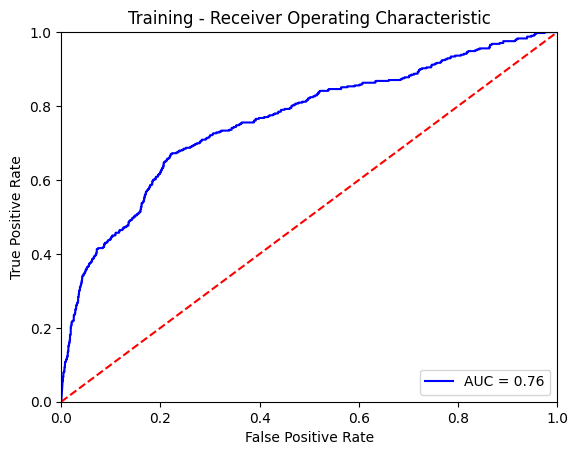

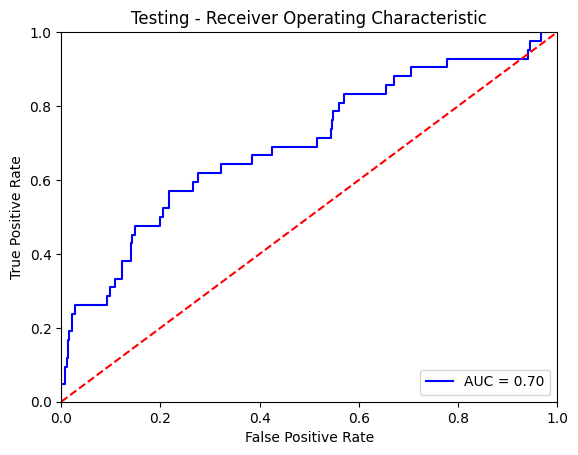

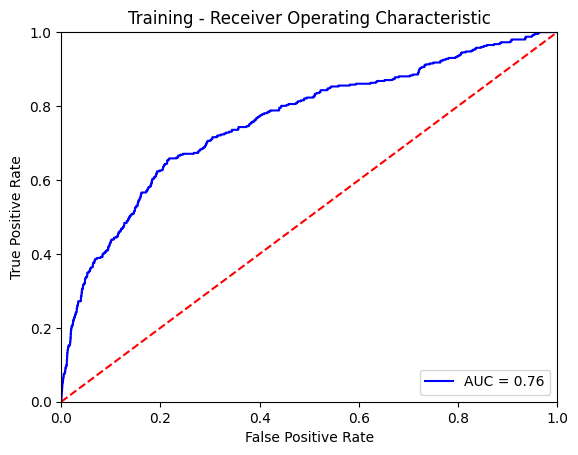

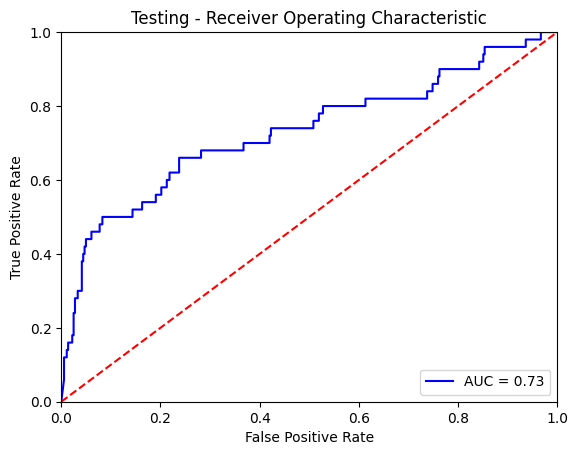

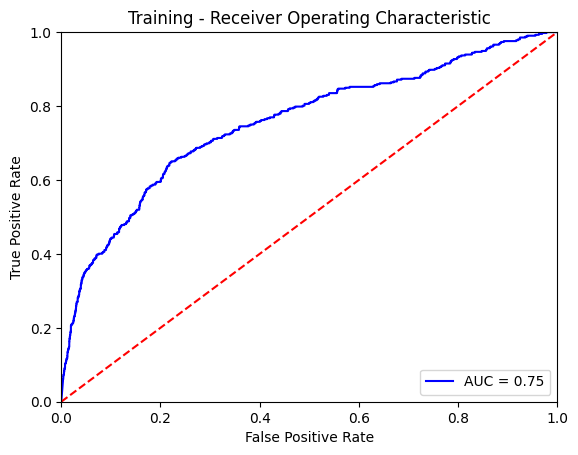

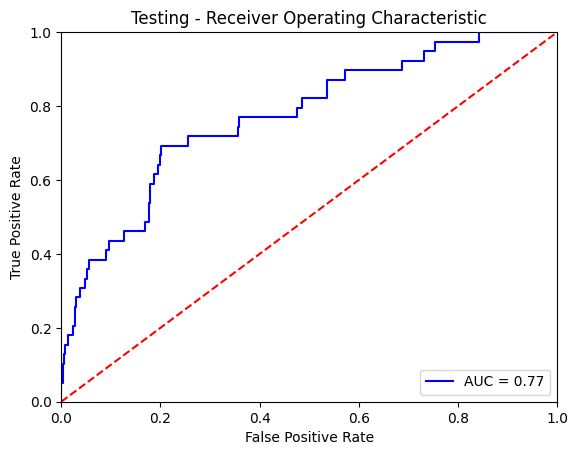

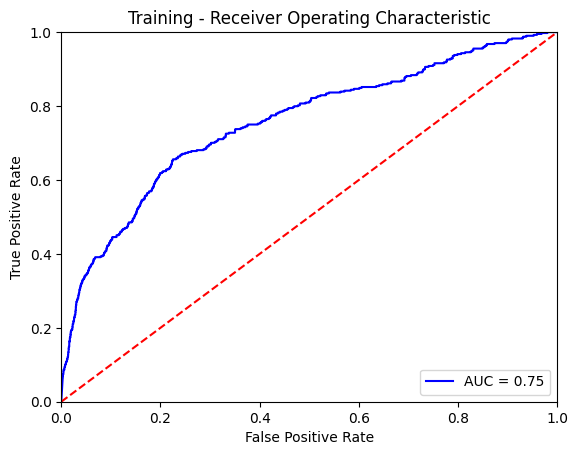

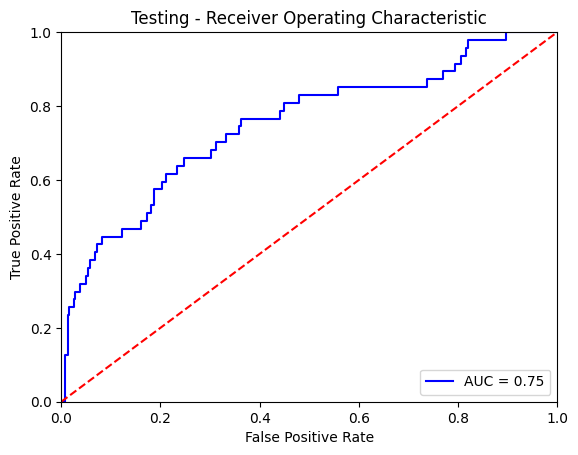

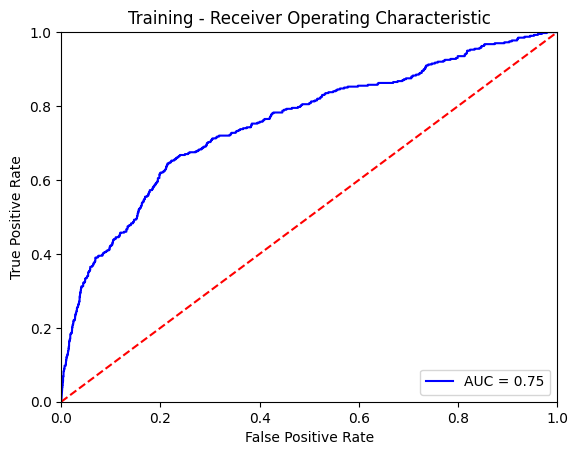

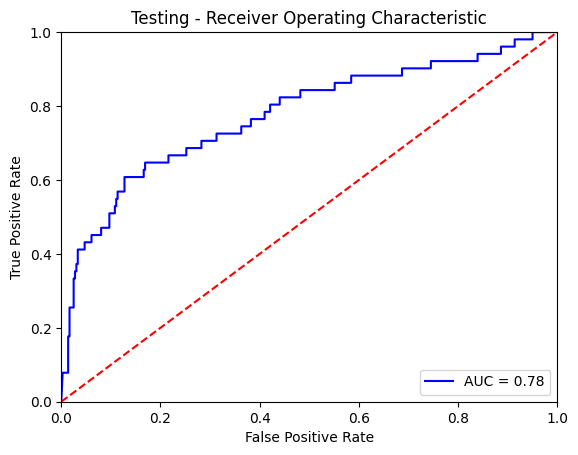

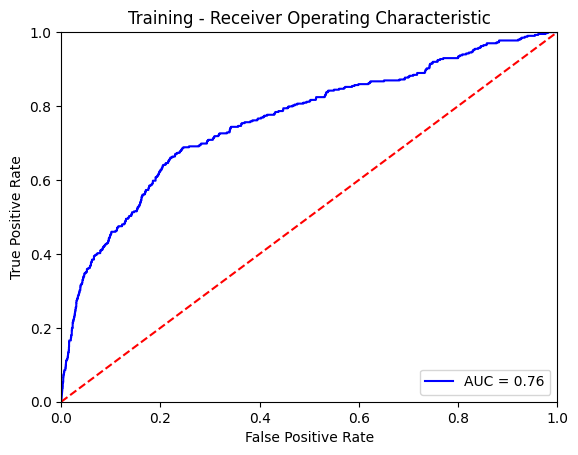

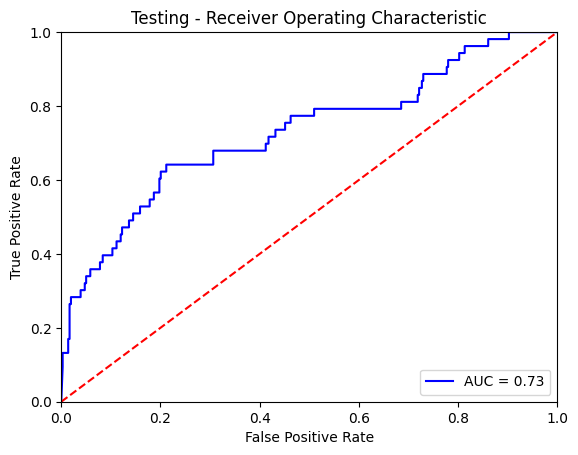

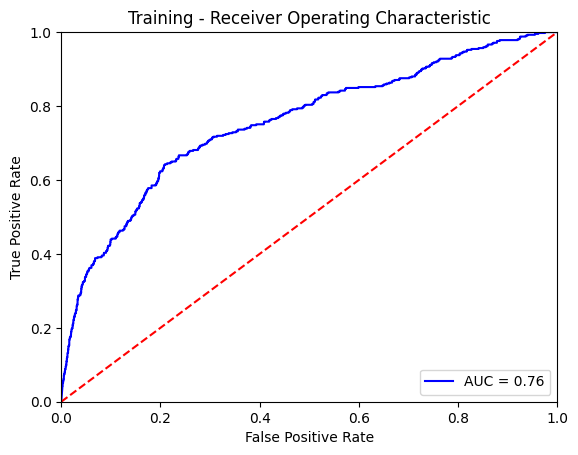

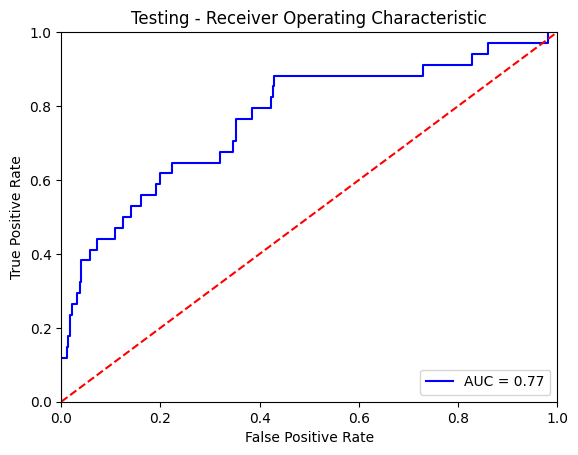

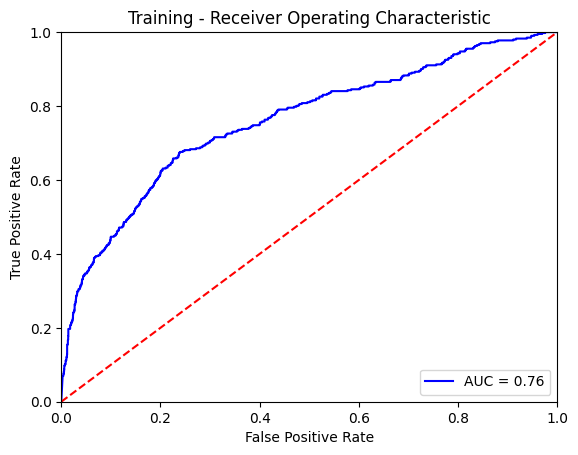

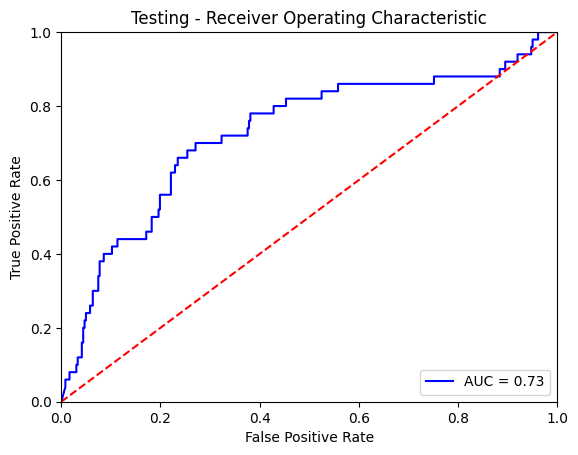

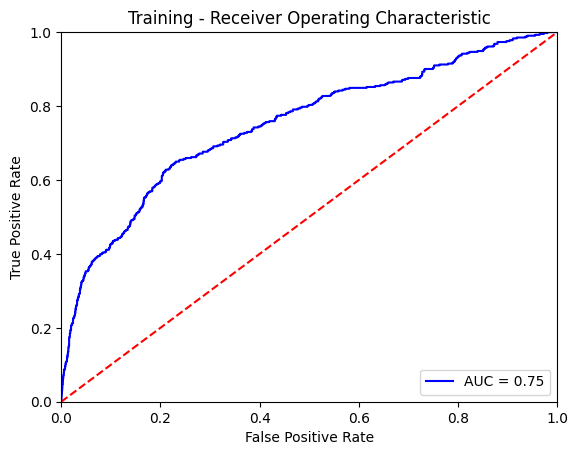

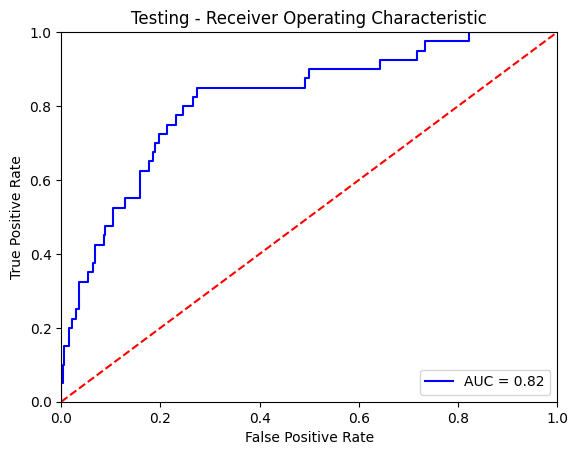

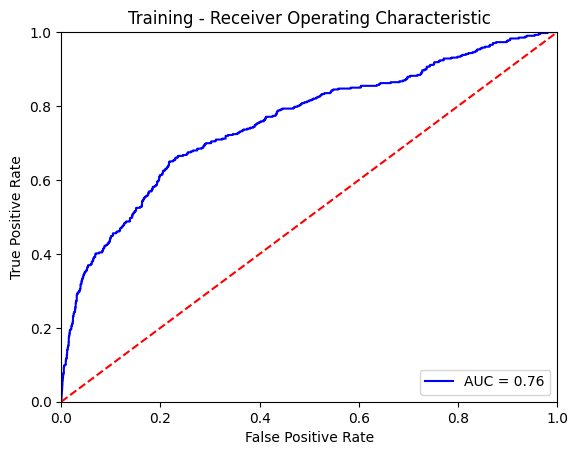

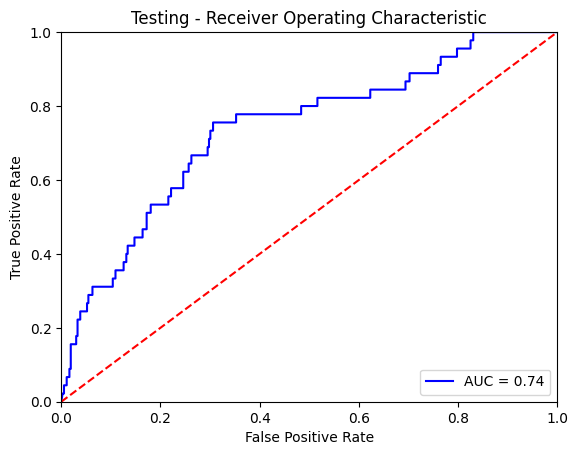

In [21]:
from sklearn.naive_bayes import GaussianNB  # ✅ 引入 Naive Bayes 模型
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix

# 忽略 alpha 和 penalty 相关参数设置
# 也不再使用内部 cross-validation 调优
num_folds = 10

# 初始化混淆矩阵累加器
train_confusion_matrices_sum = np.zeros((2, 2), dtype=int)
test_confusion_matrices_sum = np.zeros((2, 2), dtype=int)
# 用來儲存每個 fold 的表現指標
metrics_dict = {
    'train_accuracy': [],
    'test_accuracy': [],
    'train_precision': [],
    'test_precision': [],
    'train_recall': [],
    'test_recall': [],
    'train_class0_f1': [],
    'test_class0_f1': [],
    'train_class1_f1': [],
    'test_class1_f1': [],
    'train_f1': [],
    'test_f1': [],
    'train_weighted_f1': [],
    'test_weighted_f1': [],
    'train_auc': [],
    'test_auc': []
}
# 遍历 10 个 fold
for fold in range(1, num_folds + 1):
    print(f"\n=== 正在處理 Fold {fold} ===")

    train_file = f'/Users/cleazhang/Downloads/bank-additional-dataset/kfold_fold_{fold}_train.csv'
    test_file = f'/Users/cleazhang/Downloads/bank-additional-dataset/kfold_fold_{fold}_test.csv'

    df_train = pd.read_csv(train_file)
    df_test = pd.read_csv(test_file)

    if 'Unnamed: 0' in df_train.columns:
        del df_train['Unnamed: 0']
    if 'Unnamed: 0' in df_test.columns:
        del df_test['Unnamed: 0']

    df_train_class = pd.DataFrame(df_train['y'])    
    df_train_features = df_train.loc[:, df_train.columns != 'y']
    df_test_class = pd.DataFrame(df_test['y'])
    df_test_features = df_test.loc[:, df_test.columns != 'y']

    ### ✅ 使用 GaussianNB 模型
    nb_model = GaussianNB()
    nb_model.fit(df_train_features, df_train_class.values.ravel())

    predicted_train = nb_model.predict(df_train_features)
    predicted_test = nb_model.predict(df_test_features)

    predicted_prob_train = nb_model.predict_proba(df_train_features)
    predicted_prob_test = nb_model.predict_proba(df_test_features)

    print(f"\nFold {fold} 表現評估：")
    evaluate_classifier_performance(df_train_class, predicted_train, predicted_prob_train, 
                                    df_test_class, predicted_test, predicted_prob_test, 'y')

    # 計算並儲存每個 fold 的指標
    # 準確度
    train_accuracy = nb_model.score(df_train_features, df_train_class)
    test_accuracy = nb_model.score(df_test_features, df_test_class)

    metrics_dict['train_accuracy'].append(train_accuracy)
    metrics_dict['test_accuracy'].append(test_accuracy)

    # 精確度（Precision）、召回率（Recall）、F1 分數（按類別和整體）
    train_precision = precision_score(df_train_class, predicted_train, average='macro')
    test_precision = precision_score(df_test_class, predicted_test, average='macro')
    train_recall = recall_score(df_train_class, predicted_train, average='macro')
    test_recall = recall_score(df_test_class, predicted_test, average='macro')

    train_f1_per_class = f1_score(df_train_class, predicted_train, average=None)
    test_f1_per_class = f1_score(df_test_class, predicted_test, average=None)
    train_f1 = f1_score(df_train_class, predicted_train, average='macro')
    test_f1 = f1_score(df_test_class, predicted_test, average='macro')
    train_weighted_f1 = f1_score(df_train_class, predicted_train, average='weighted')
    test_weighted_f1 = f1_score(df_test_class, predicted_test, average='weighted')

    metrics_dict['train_precision'].append(train_precision)
    metrics_dict['test_precision'].append(test_precision)
    metrics_dict['train_recall'].append(train_recall)
    metrics_dict['test_recall'].append(test_recall)
    metrics_dict['train_class0_f1'].append(train_f1_per_class[0])
    metrics_dict['test_class0_f1'].append(test_f1_per_class[0])
    metrics_dict['train_class1_f1'].append(train_f1_per_class[1])
    metrics_dict['test_class1_f1'].append(test_f1_per_class[1])
    metrics_dict['train_f1'].append(train_f1)
    metrics_dict['test_f1'].append(test_f1)
    metrics_dict['train_weighted_f1'].append(train_weighted_f1)
    metrics_dict['test_weighted_f1'].append(test_weighted_f1)

    # AUC
    train_auc = roc_auc_score(df_train_class, predicted_prob_train[:, 1])
    test_auc = roc_auc_score(df_test_class, predicted_prob_test[:, 1])
    metrics_dict['train_auc'].append(train_auc)
    metrics_dict['test_auc'].append(test_auc)
    train_confusion_matrices_sum += confusion_matrix(df_train_class, predicted_train)
    test_confusion_matrices_sum += confusion_matrix(df_test_class, predicted_test)


# 計算平均值和標準差，並生成最終表格
metrics_summary = {}
for metric, values in metrics_dict.items():
    mean_value = np.mean(values)
    std_value = np.std(values)
    metrics_summary[metric] = f"{mean_value:.4f} ± {std_value:.4f}"

# 將結果整理成表格
summary_df = pd.DataFrame({
    'Accuracy': [metrics_summary['train_accuracy'], metrics_summary['test_accuracy']],
    'Precision': [metrics_summary['train_precision'], metrics_summary['test_precision']],
    'Recall': [metrics_summary['train_recall'], metrics_summary['test_recall']],
    'Class 0 F1': [metrics_summary['train_class0_f1'], metrics_summary['test_class0_f1']],
    'Class 1 F1': [metrics_summary['train_class1_f1'], metrics_summary['test_class1_f1']],
    'F1 Score': [metrics_summary['train_f1'], metrics_summary['test_f1']],
    'Weighted F1 Score': [metrics_summary['train_weighted_f1'], metrics_summary['test_weighted_f1']],
    'AUC': [metrics_summary['train_auc'], metrics_summary['test_auc']]
}, index=['Train', 'Test'])

# 輸出最終結論
print("\n=== 10 折交叉驗證最終結論 ===")
print("Model Evaluation")
print(summary_df)

summary_df.to_csv('model_evaluation_summary.csv')
np.savetxt('train_confusion_matrix_sum.csv', train_confusion_matrices_sum, delimiter=',', fmt='%d')
np.savetxt('test_confusion_matrix_sum.csv', test_confusion_matrices_sum, delimiter=',', fmt='%d')

